In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.svm import SVC
from sklearn.svm import LinearSVC as LSVC
from sklearn.decomposition import TruncatedSVD as TSVD
from scipy.sparse import hstack
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA



# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

# SK-learn libraries for model selection 
from sklearn.model_selection import train_test_split

# json libraries to parse json file
import json
from pandas.io.json import json_normalize

import gensim
from gensim import utils

/Users/lauc136/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/lauc136/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# 0.1 Helper Function

In [2]:
def plot_roc(y_test, y_score):
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr[0], tpr[0], _ = roc_curve(y_test, y_score)
    roc_auc[0] = auc(fpr[0], tpr[0])

    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()


In [5]:
def construct_features(data):
    features=pd.DataFrame()
    
    features['community_age'] = (pd.to_datetime(data['unix_timestamp_of_request_utc'],utc = True, unit = 's') - \
                                pd.to_datetime('2010-12-8', format='%Y-%m-%d')).astype('timedelta64[D]')
    
    features['community_age'] = (features['community_age'] * 10./features.community_age.max()).astype(int)

    features['first_half_of_month']=(pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's').dt.day <= 15).astype(int) 

    features['gratitude'] = data['request_text_edit_aware'].apply( \
                                    lambda x: 1 if re.search("thank|appreciate|advance|consider", x) else 0)
    features['include_image'] = data['request_text_edit_aware'].apply(lambda x: 1 if re.search("imgur.com|.jpg|.png|.jpeg", x) else 0)

    features['reciprocity'] = data['request_text_edit_aware'].apply(\
                                    lambda x:1 if re.search("repay|pay.+back|pay.+forward|return.+favor|reciprocate", x) else 0)
    features['len_request']= (data['request_text_edit_aware'].apply(len) > 100).astype(int)

    features['karma']=(data.requester_upvotes_minus_downvotes_at_request - data.requester_upvotes_minus_downvotes_at_request.mean()) \
                                /data.requester_upvotes_minus_downvotes_at_request.std()
    features['karma'] = ((features.karma - features.karma.min()) * 3).astype(int)

    features['posted_in_raop_before']= (data['requester_number_of_posts_on_raop_at_request'] > 0).astype(int)
    
    features['posted_before']= (data['requester_number_of_posts_at_request'] > 0).astype(int)
    
    return features

In [218]:
money = ["money", "now", "broke", "week", "until", "time",
          "last", "day", "when", "today", "tonight", "paid", "next",
          "first", "night", "after", "tomorrow", "month", "while",
          "account", "before", "long", "Friday", "rent", "buy",
          "bank", "still", "bills", "ago", "cash", "due",
          "soon", "past", "never", "paycheck", "check", "spent",
          "years", "poor", "till", "yesterday", "morning", "dollars",
          "financial", "hour", "bill", "evening", "credit",
          "budget", "loan", "bucks", "deposit", "dollar", "current",
          "payed"]
job =["work", "job", "paycheck", "unemployment", "interview",
          "fired", "employment", "hired", "hire"]
student = ["college", "student", "school", "roommate",
          "studying", "university", "finals", "semester",
          "class", "study", "project", "dorm", "tuition"]
family =["family", "mom", "wife", "parents", "mother", "husband",
           "dad", "son", "daughter", "father", "parent",
           "mum"]
craving = ["friend", "girlfriend", "craving", "birthday",
          "boyfriend", "celebrate", "party", "game", "games",
          "movie", "date", "drunk", "beer", "celebrating", "invited",
          "drinks", "crave", "wasted", "invite"]

narratives = [money, job, student, family, craving]

def find_narr(narr,s):
    ct=0
    for word in narr:
        ct+=s.split().count(word)
    #return ct/len(s.split())
    return ct


def construct_topic_features(data): 
    
    data['full_text'] = data['request_text_edit_aware'] + ' ' + data['request_title']
    clean_text = data['full_text'].apply(lambda s:preprocessor(s))

    features = pd.DataFrame()

    for n in narratives:
        features[n[0]] = clean_text.apply(lambda s: find_narr(n,s))
    return features

# 1.0 LOAD DATA

In [206]:
# read json file
train_json = json.load(open('train.json'))

# normalize data and put in a dataframe
train_json_df = json_normalize(train_json)

# read json file
test_json = json.load(open('test.json'))

# normalize data and put in a dataframe
test_json_df = json_normalize(test_json)

In [207]:
columns = test_json_df.columns.values
columns = np.append(columns, ['requester_received_pizza'])

train_json_with_test_df = train_json_df[columns]


# 2.0 EDA

In [9]:
train_json_with_test_df[train_json_with_test_df.requester_received_pizza ==1].describe()

,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,unix_timestamp_of_request,unix_timestamp_of_request_utc
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,9.940000e+02,9.940000e+02,9.940000e+02
mean,276.766844,28.563757,126.528169,1.429577,23.437626,0.141851,19.509054,1372.060362,4.923700e+03,1.338609e+09,1.338606e+09
std,312.791210,96.767955,202.328504,5.914937,52.502996,0.526249,21.352374,5419.691555,4.216637e+04,2.317988e+07,2.317956e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-39.000000,0.000000e+00,1.306095e+09,1.306091e+09
25%,39.110437,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,23.250000,4.500000e+01,1.316329e+09,1.316325e+09
50%,179.528218,0.000000,35.000000,0.000000,6.000000,0.000000,13.000000,285.500000,5.620000e+02,1.336384e+09,1.336381e+09
75%,396.927688,0.000000,155.000000,0.000000,24.000000,0.000000,28.000000,1382.750000,2.937250e+03,1.359247e+09,1.359247e+09
max,2124.362650,785.457685,990.000000,88.000000,627.000000,5.000000,128.000000,155010.000000,1.286864e+06,1.381297e+09,1.381268e+09


In [10]:
train_json_with_test_df[train_json_with_test_df.requester_received_pizza ==0].describe()

,requester_account_age_in_days_at_request,requester_days_since_first_post_on_raop_at_request,requester_number_of_comments_at_request,requester_number_of_comments_in_raop_at_request,requester_number_of_posts_at_request,requester_number_of_posts_on_raop_at_request,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_plus_downvotes_at_request,unix_timestamp_of_request,unix_timestamp_of_request_utc
count,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3046.000000,3.046000e+03,3.046000e+03
mean,247.348502,12.453199,111.368352,0.389035,21.002298,0.038083,17.609324,1090.904465,3358.015430,1.344206e+09,1.344203e+09
std,299.802716,59.190392,190.172257,1.944889,50.353551,0.218656,21.843488,2956.582633,17467.638203,2.321784e+07,2.321705e+07
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,1.297723e+09,1.297723e+09
25%,0.005729,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,4.000000,1.322381e+09,1.322381e+09
50%,144.698495,0.000000,20.000000,0.000000,4.000000,0.000000,10.000000,135.500000,270.500000,1.344057e+09,1.344053e+09
75%,385.869005,0.000000,134.000000,0.000000,21.000000,0.000000,27.000000,1082.500000,2134.250000,1.365886e+09,1.365882e+09
max,2809.750787,739.771007,994.000000,52.000000,867.000000,3.000000,186.000000,87911.000000,789287.000000,1.381552e+09,1.381523e+09


## Sample data

In [19]:
train_data = train_json_with_test_df.request_text_edit_aware.as_matrix()
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232,)
dev data shape: (808,)


In [20]:
import random
num_examples=10
    
# for each label, display a number of examples 
for i in range(2):

    # find the indexes of the corresponding label 
    index = np.where(train_labels == i)

    for j in range(num_examples):

        # print the training data for that label
        if i == 0:
            title = "This request receives pizza"
        else:
            title = "This request doesn't receive pizza"
        print("-----------------------------------------------" )
        print("{} : Sample {}".format(title, j+1))
        
        for k in narratives:
            print("{}:{}".format(k[0], find_narr(k, train_data[index[0][j]])))
        
        print("gratitude : {}".format(1 if re.search("thank|appreciate|advance|consider", train_data[index[0][j]]) else 0))
        print("include_image : {}".format(1 if re.search("http|www|screenshot|photo|image", train_data[index[0][j]]) else 0))
        print("reciprocity : {}".format(1 if re.search("repay|pay.+back|pay.+forward|return.+favor|reciprocate", train_data[index[0][j]]) else 0))

        print("-----------------------------------------------")
        print(train_data[index[0][j]])
        print("\n")

-----------------------------------------------
This request receives pizza : Sample 1
money:3
work:0
college:0
family:0
friend:0
gratitude : 0
include_image : 0
reciprocity : 0
-----------------------------------------------
My power was out for about 3 hours earlier this afternoon. I keep trying to watch DVD's (Twister...I mean when in Rome, right?) but as soon as I get halfway in the power either flickers on and off or stays off for an extended period of time. I don't feel up to going out for food either since I've been sick for about 3 days now and Hurricane Irene is being a bitch...

Thank you all!


-----------------------------------------------
This request receives pizza : Sample 2
money:3
work:1
college:0
family:0
friend:0
gratitude : 0
include_image : 0
reciprocity : 0
-----------------------------------------------
I'm lucky that internet comes part and parcel with my rent. I work retail grocery and summer hours are murder on the wallet. I have to hustle managers just to ge

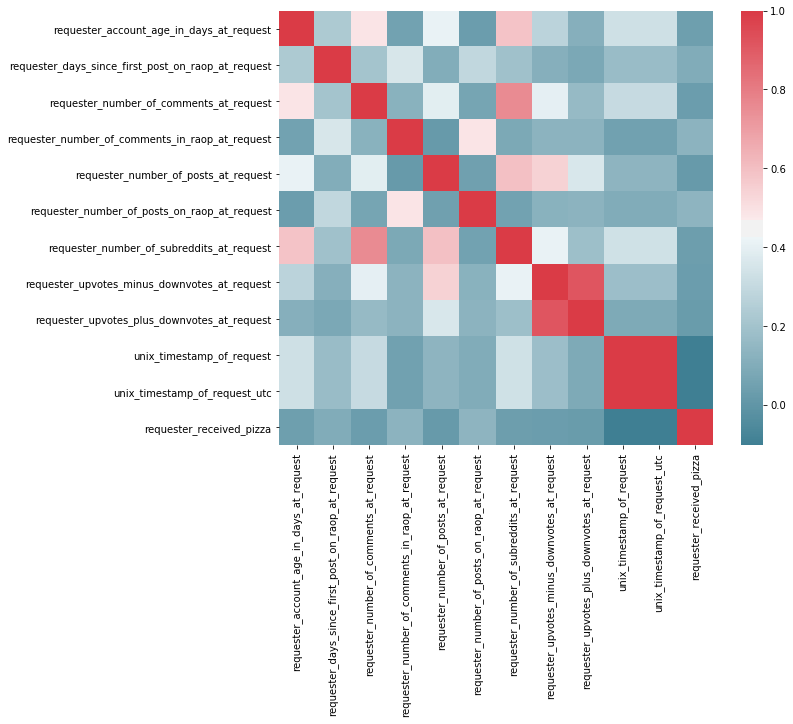

In [18]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = train_json_with_test_df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [265]:
train_data = train_json_with_test_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232, 18)
dev data shape: (808, 18)


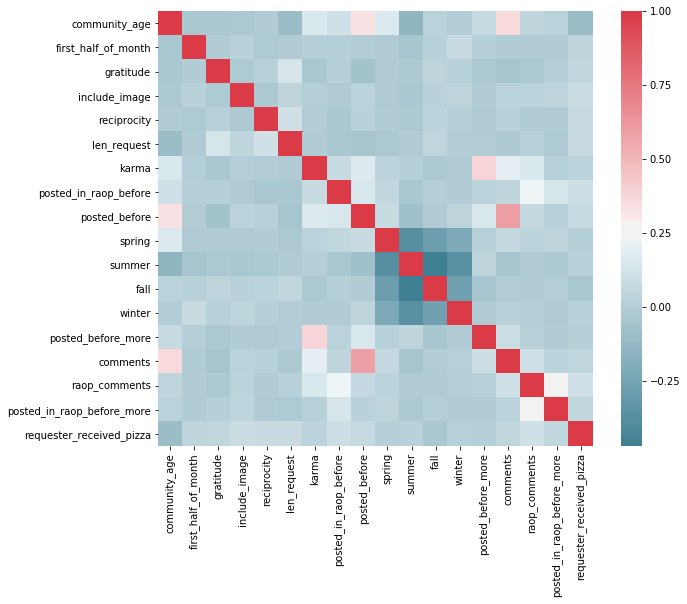

In [362]:
train_features = construct_more_features(train_data)

train_features['requester_received_pizza'] = train_labels

f, ax = plt.subplots(figsize=(10, 8))
corr = train_features.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

# 2.0 EDA - Logistic Regression

In [25]:
def preprocessor_old(s):
    
    if len(s) > 0:
        
        # change the data to lower case 
        s = s.lower()
        
        # change name pattern, for exmaple, emmy c. lau to emmyclau
        name_pattern = re.compile(r'(\w+)\s(\w)\.\s(\w+)')
        s= re.sub(name_pattern, r'\1\2\3', s)
        
        # change email pattern, for exmaple, emmylau@berkeley.edu to emmylauberkeleyedu
        email_pattern = re.compile(r'(\w+)@(\w+)\.(\w+)')
        s= re.sub(email_pattern, r'\1\2\3', s)
        
        # change url pattern, for example, http://yahoo.com to URL
        url_pattern = re.compile(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
        s= re.sub(url_pattern, r'URL', s)
        
        # remove the leading '_'
        s = re.sub(r'\b_', '', s)
        
        # replace all non-word character to ' ' 
        s = re.sub(r'\W+', ' ', s)
        
        # replace all numeric sequence to '####'
        s = re.sub(r'\d+', '####', s)
        
        # truncate all words to the first 5 characters 
        s = " ".join(x[:5]  for x in s.split(' ') )        
    return s 

In [26]:
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer

def preprocessor(s):
    
    if len(s) > 0:
        
        s=s.lower()
        
        # replace all non-word character to ' ' 
        s = re.sub(r'\W+', ' ', s)
        
        # replace all numeric sequence to '####'
        s = re.sub(r'\d+', '####', s)
        
        #p_stemmer = PorterStemmer()
        #s = ' '.join([p_stemmer.stem(i) for i in s.split()])
        
        s_stemmer = SnowballStemmer('english')
        s = ' '.join([s_stemmer.stem(i) for i in s.split()])
        
        
        
    return s
    

## 2.1 Just Bag Of Words

In [27]:
train_data = train_json_df.request_text_edit_aware.as_matrix()
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232,)
dev data shape: (808,)


In [28]:
vectorizer = CountVectorizer(min_df = 2, stop_words='english', ngram_range = (1, 1), preprocessor=preprocessor)
train_bag_of_words = vectorizer.fit_transform(train_data)
dev_bag_of_words = vectorizer.transform(dev_data)
print(train_bag_of_words.shape)

lr = LogisticRegression(tol=0.01)
#parameters = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
parameters = {'C':np.linspace(0.005, 0.1, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_bag_of_words, train_labels) 
pred_dev_prob = clf.predict_proba(dev_bag_of_words)[:,1]
pred_dev_labels = clf.predict(dev_bag_of_words)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

(3232, 3713)
{'C': 0.0078787878787878792}


0.55511364087419723

In [29]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))
dev_labels[dev_labels != pred_dev_labels]

Request receives pizza = 211
Request failed to predict receiving pizza = 209


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

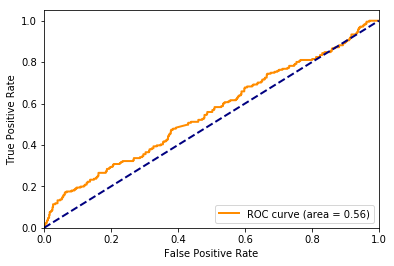

array([[595,   2],
       [209,   2]])

In [30]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

## 2.2 Bag of words + additional features

In [31]:
# training labels
train_labels = train_json_with_test_df.requester_received_pizza.astype(int)

# text factors
vectorizer = CountVectorizer(min_df = 2, stop_words='english', ngram_range = (1, 1), preprocessor=preprocessor)
train_bag_of_words = vectorizer.fit_transform(train_json_with_test_df.request_text_edit_aware.as_matrix(), train_labels)

# other factors
train_other_data = train_json_with_test_df[['requester_account_age_in_days_at_request', \
                                    'requester_days_since_first_post_on_raop_at_request', \
                                    'requester_number_of_comments_at_request', \
                                    'requester_number_of_comments_in_raop_at_request', \
                                    'requester_number_of_posts_at_request', \
                                    'requester_number_of_posts_on_raop_at_request', \
                                    'requester_number_of_subreddits_at_request', \
                                    'requester_upvotes_minus_downvotes_at_request', \
                                    'requester_upvotes_plus_downvotes_at_request']].as_matrix()

print(train_bag_of_words.shape)
print(train_other_data.shape)
train_data = np.hstack((train_bag_of_words.todense(), train_other_data))


# split the training data into training data and dev data 
train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    

(4040, 4174)
(4040, 9)


In [32]:
lr = LogisticRegression()
#parameters = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
parameters = {'C':np.linspace(0.005, 0.1, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_data, train_labels)
pred_dev_prob = clf.predict_proba(dev_data)[:,1]
pred_dev_labels = clf.predict(dev_data)


print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.0088383838383838381}


0.57231655909881163

In [33]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))

Request receives pizza = 211
Request failed to predict receiving pizza = 198


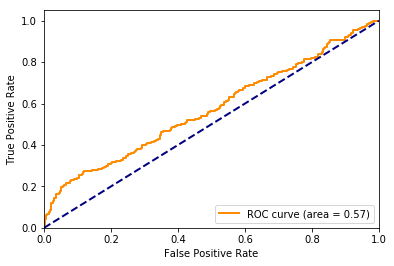

array([[592,   5],
       [198,  13]])

In [34]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

## 2.3 Just Topics with NMF 

In [389]:
train_data = train_json_df.request_text_edit_aware.as_matrix()
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232,)
dev data shape: (808,)


In [390]:
TfidfTransformer;
from sklearn.decomposition import NMF;
from sklearn.preprocessing import normalize;
import pandas as pd;

vectorizer = CountVectorizer(analyzer='word', stop_words='english');
train_bag_of_words = vectorizer.fit_transform(train_data);
dev_bag_of_words = vectorizer.transform(dev_data)

transformer = TfidfTransformer(smooth_idf=False, norm='l1');
train_tfidf = transformer.fit_transform(train_bag_of_words);
dev_tfidf = transformer.transform(dev_bag_of_words)

In [391]:
num_topics=20
model = NMF(n_components=num_topics, init='nndsvd');

#fit the model
model.fit(train_tfidf)

NMF(alpha=0.0, beta_loss='frobenius', init='nndsvd', l1_ratio=0.0,
  max_iter=200, n_components=20, random_state=None, shuffle=False,
  solver='cd', tol=0.0001, verbose=0)

In [392]:
def get_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-20 - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);
get_topics(model, 20)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,Topic # 11,Topic # 12,Topic # 13,Topic # 14,Topic # 15,Topic # 16,Topic # 17,Topic # 18,Topic # 19,Topic # 20
0,money,pizza,thank,appreciated,love,hungry,buy,appreciate,thanks,edit,forward,eat,doing,california,just,generous,favor,test,halp,forever
1,food,like,consideration,greatly,pie,help,cheese,greatly,help,nevermind,pay,help,right,illustrator,want,pie,return,studying,liek,lt
2,really,good,reddit,reciprocated,family,student,people,really,redditors,location,ll,broke,tonight,adding,student,feeling,friday,nighter,college,ll
3,don,celebrate,hope,payed,wired,broke,works,college,yall,adding,asap,house,sure,location,college,amazing,says,pulling,pizzas,long
4,day,haven,guys,later,really,pretty,week,brother,advance,pie,means,boyfriend,ve,say,sob,cookout,title,awww,cook,friend
5,today,hut,pizzareceived,help,tonight,blasting,soul,thanks,lexically,spelling,money,year,craving,like,story,starving,person,promises,apartment,gonna
6,paid,craving,raop,max,sister,college,great,reading,mwaahhh,error,friday,poor,really,cool,craving,sir,reddit,pass,moved,com
7,job,really,advance,super,forever,music,hopefully,student,wa,imagine,paid,college,honesty,live,pie,redditor,random,use,recently,http
8,week,nice,suffolk,monies,gift,nice,advance,home,reading,night,week,today,visiting,hope,hut,looking,paid,yeah,know,imgur
9,work,cheese,hopefully,weeks,reading,say,coupon,dope,wants,bestow,possible,kids,awkward,im,say,offer,offer,tonight,don,guys


In [39]:
train_data_with_topics = model.transform(train_tfidf)
dev_data_with_topics = model.transform(dev_tfidf)

In [40]:
dev_data_with_topics[[]]

array([], shape=(0, 20), dtype=float64)

In [41]:
for i in range(0, num_topics, 1):
    print("success rate for topic #{} = {}".format(i+1, \
                                    np.sum(train_labels[train_data_with_topics[:, i] > 0])/train_labels.size))

success rate for topic #1 = 0.2311262376237624
success rate for topic #2 = 0.18347772277227722
success rate for topic #3 = 0.11695544554455446
success rate for topic #4 = 0.10179455445544554
success rate for topic #5 = 0.10798267326732673
success rate for topic #6 = 0.11045792079207921
success rate for topic #7 = 0.10426980198019802
success rate for topic #8 = 0.10024752475247525
success rate for topic #9 = 0.13675742574257427
success rate for topic #10 = 0.14077970297029702
success rate for topic #11 = 0.13521039603960397
success rate for topic #12 = 0.12097772277227722
success rate for topic #13 = 0.09034653465346534
success rate for topic #14 = 0.08570544554455446
success rate for topic #15 = 0.11231435643564357
success rate for topic #16 = 0.08787128712871287
success rate for topic #17 = 0.08106435643564357
success rate for topic #18 = 0.0853960396039604
success rate for topic #19 = 0.1630569306930693
success rate for topic #20 = 0.08879950495049505


In [48]:
#just use the first 2 topics to classify

lr = LogisticRegression()
#parameters = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
parameters = {'C':np.linspace(0.0005, 0.1, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_data_with_topics, train_labels)
pred_dev_prob = clf.predict_proba(dev_data_with_topics)[:,1]
pred_dev_labels = clf.predict(dev_data_with_topics)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.00050000000000000001}


0.51440456627529429

In [49]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))

Request receives pizza = 211
Request failed to predict receiving pizza = 211


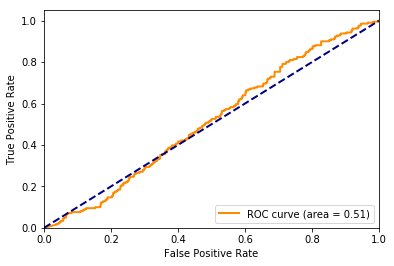

array([[597,   0],
       [211,   0]])

In [50]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

## 2.3.1 Just Topics with LDA

In [395]:
train_data = train_json_with_test_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232, 18)
dev data shape: (808, 18)


In [397]:
train_data['full_text'] = train_data['request_text_edit_aware'] + ' ' + train_data['request_title']
dev_data['full_text'] = dev_data['request_text_edit_aware'] + ' ' + dev_data['request_title']
        

/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [398]:
vectorizer_lda = CountVectorizer(min_df=10,ngram_range=(1,1), preprocessor=preprocessor,stop_words='english') 
lda_bag_of_words = vectorizer_lda.fit_transform(train_data['full_text'])
lda_devbag_of_words = vectorizer_lda.transform(dev_data['full_text'])

In [399]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

num_topics=3
lda = LDA(n_components=num_topics, learning_method="batch", max_iter=30,learning_decay=.7, random_state=42)

train_lda_topics = lda.fit_transform(lda_bag_of_words)
dev_lda_topics=lda.transform(lda_devbag_of_words)


In [400]:
get_topics(lda, 20)

,Topic # 01,Topic # 02,Topic # 03
0,attending,aloud,attending
1,backwoods,afflicted,backwoods
2,altruistic,backwoods,afflicted
3,booted,accident,20euros
4,andy,borrowing,bitch
5,6months,bonded,airman
6,awkward,bowls,accident
7,bowls,altruistic,answer
8,antoons,appreciation,assistant
9,answer,appreciating,appreciating


In [401]:
lr = LogisticRegression()
#parameters = {'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]}
parameters = {'C':np.linspace(0.0005, 0.1, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_lda_topics, train_labels)
pred_dev_prob = clf.predict_proba(dev_lda_topics)[:,1]
pred_dev_labels = clf.predict(dev_lda_topics)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.00050000000000000001}


0.56182174696547504

In [402]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))

Request receives pizza = 211
Request failed to predict receiving pizza = 211


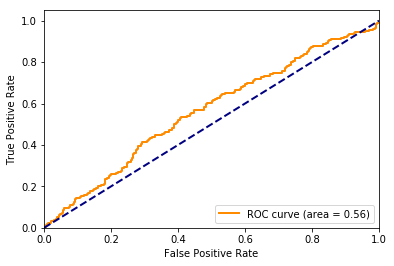

array([[597,   0],
       [211,   0]])

In [403]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

## 2.4 Just Topics (from the Stanford Paper)

In [51]:
train_data = train_json_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)


training data shape: (3232, 32)
dev data shape: (808, 32)


In [52]:
train_topic_features = construct_topic_features(train_data)
dev_topic_features = construct_topic_features(dev_data)



/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
lr = LogisticRegression(tol=0.01)
parameters = {'C':[0.000001, 0.00001, 0.01, 0.1, 1]}
clf = GridSearchCV(lr, parameters)
clf.fit(train_topic_features, train_labels)
pred_dev_prob = clf.predict_proba(dev_topic_features)[:,0]
pred_dev_labels = clf.predict(dev_topic_features)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 1e-06}


0.60391610501163007

In [54]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))

Request receives pizza = 211
Request failed to predict receiving pizza = 211


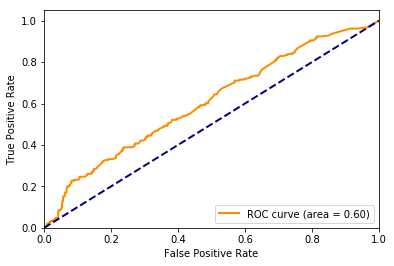

array([[597,   0],
       [211,   0]])

In [55]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

## 2.5 Just Non-Text Features (from the Stanford Paper)

In [56]:
train_data = train_json_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232, 32)
dev data shape: (808, 32)


In [57]:
train_features = construct_features(train_data)
dev_features = construct_features(dev_data)

In [58]:
lr = LogisticRegression(tol=0.01)
#parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1]}
parameters = {'C':np.linspace(0.05, 0.5, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_features, train_labels)
pred_dev_prob = clf.predict_proba(dev_features)[:,1]
pred_dev_labels = clf.predict(dev_features)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.20909090909090911}


0.66926655393873002

In [59]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))

Request receives pizza = 211
Request failed to predict receiving pizza = 200


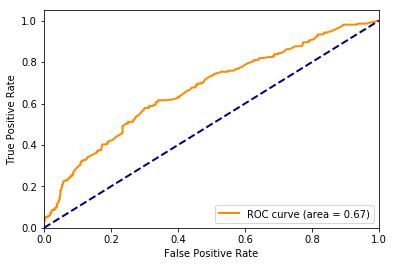

array([[593,   4],
       [200,  11]])

In [60]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

## 2.6 Topics + Bag of Words (from the Stanford Paper)

In [61]:
train_data = train_json_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232, 32)
dev data shape: (808, 32)


In [62]:
train_topic_features = construct_topic_features(train_data)
dev_topic_features = construct_topic_features(dev_data)


/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [63]:
vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,2), preprocessor=preprocessor,stop_words='english',norm='l2',sublinear_tf=True) 
train_bag_of_words = vectorizer.fit_transform(train_data['full_text'])
dev_bag_of_words = vectorizer.transform(dev_data['full_text'])

In [64]:
train_features = hstack([train_topic_features, train_bag_of_words])
dev_features = hstack([dev_topic_features, dev_bag_of_words])

In [65]:
lr = LogisticRegression(tol=0.01)
parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1]}
#parameters = {'C':np.linspace(0.05, 0.5, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_features, train_labels)
pred_dev_prob = clf.predict_proba(dev_features)[:,0]
pred_dev_labels = clf.predict(dev_features)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.0001}


0.60415823191788331

In [66]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))

Request receives pizza = 211
Request failed to predict receiving pizza = 211


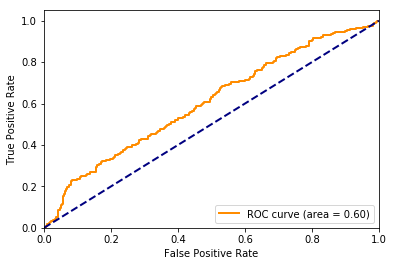

array([[597,   0],
       [211,   0]])

In [67]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

## 2.7 Non-Text Features + Topics (from the Stanford Paper)

In [68]:
train_data = train_json_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232, 32)
dev data shape: (808, 32)


In [69]:
train_topic_features = construct_topic_features(train_data)
dev_topic_features = construct_topic_features(dev_data)


/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [70]:
train_other_features = construct_features(train_data)
dev_other_features = construct_features(dev_data)

In [71]:
train_features = hstack([train_other_features, train_topic_features])
dev_features = hstack([dev_other_features, dev_topic_features])

In [72]:
lr = LogisticRegression(tol=0.01)
#parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1]}
parameters = {'C':np.linspace(0.05, 0.5, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_features, train_labels)
pred_dev_prob = clf.predict_proba(dev_features)[:,1]
pred_dev_labels = clf.predict(dev_features)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.14999999999999999}


0.68208737208951553

In [73]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))

Request receives pizza = 211
Request failed to predict receiving pizza = 189


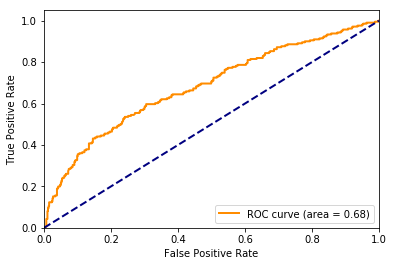

array([[589,   8],
       [189,  22]])

In [74]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

## 2.8 Non-Text Features + Topics + Bag Of Words (from the Stanford Paper)

In [75]:
train_data = train_json_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232, 32)
dev data shape: (808, 32)


In [76]:
train_topic_features = construct_topic_features(train_data)
dev_topic_features = construct_topic_features(dev_data)


/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [77]:
train_other_features = construct_features(train_data)
dev_other_features = construct_features(dev_data)

In [78]:
vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,2), preprocessor=preprocessor,stop_words='english',norm='l2',sublinear_tf=True) 
train_bag_of_words = vectorizer.fit_transform(train_data['full_text'])
dev_bag_of_words = vectorizer.transform(dev_data['full_text'])

In [80]:
train_features = hstack([train_other_features, train_topic_features, train_bag_of_words])
dev_features = hstack([dev_other_features, dev_topic_features, dev_bag_of_words])

In [81]:
lr = LogisticRegression(tol=0.01)
#parameters = {'C':[0.01, 0.1, 1, 10, 100]}
parameters = {'C':np.linspace(0.5, 5, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_features, train_labels)
pred_dev_prob = clf.predict_proba(dev_features)[:,1]
pred_dev_labels = clf.predict(dev_features)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 1.0454545454545454}


0.68046393102955538

In [82]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))

Request receives pizza = 211
Request failed to predict receiving pizza = 180


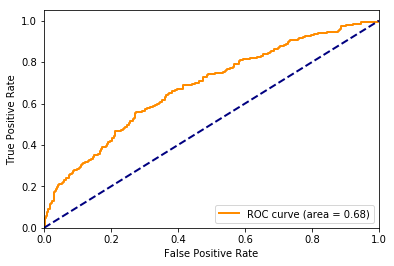

array([[580,  17],
       [180,  31]])

In [83]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

## 2.8 More Non-Text Features 

In [84]:
train_data = train_json_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232, 32)
dev data shape: (808, 32)


In [85]:
def time_of_day(s):
    if s > 5 and s <= 12:
        return "morning"
    elif s > 12 and s <= 18:
        return "afternoon"
    elif s > 18 and s <= 23:
        return "night"
    else:
        return "latenight"
    
    
def day_of_week(s):
    if s >= 0 and s <= 3:
        return "weekday"
    else:
        return "weekend"
    
def season(month):
    if month>=3 and month<=5:
        return "spring"
    elif month>=6 and month <=8:
        return "summer"
    elif month>=9 and month <=11:
        return "fall"
    else:
        return "winter"

In [86]:
def construct_more_features(data):

    features=construct_features(data)
    
    # additional non-text features
    features['spring'] = ((pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's')).dt.month.apply(season) == "spring").astype(int) 
    features['summer'] = ((pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's')).dt.month.apply(season) == "summer").astype(int)
    features['fall'] = ((pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's')).dt.month.apply(season) == "fall").astype(int)
    features['winter'] = ((pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's')).dt.month.apply(season) == "winter").astype(int)
        

    features['posted_before_more']= (data['requester_number_of_posts_at_request'] > 100).astype(int)
    features['comments'] = (data['requester_number_of_comments_at_request'] > 20).astype(int)
    features['raop_comments'] = (data['requester_number_of_comments_in_raop_at_request'] > 10).astype(int)
    features['posted_in_raop_before_more']= (data['requester_number_of_posts_on_raop_at_request'] > 3).astype(int)
    
    #features['upvotes_minus_downvotes']= data['requester_upvotes_minus_downvotes_at_request'] > 
    #features['upvotes_plus_downvotes_at_request']=np.log(train_data['requester_upvotes_plus_downvotes_at_request']+1)
    #upvotes=data.apply(lambda row: (row['requester_upvotes_plus_downvotes_at_request'] + row['requester_upvotes_minus_downvotes_at_request'])/2,axis=1)
    #downvotes=data.apply(lambda row: (row['requester_upvotes_plus_downvotes_at_request']- row['requester_upvotes_minus_downvotes_at_request'])/2,axis=1)
    #features['vote_ratio']=upvotes/(upvotes+downvotes+1)
    
    return features

In [87]:
train_features = construct_more_features(train_data)
dev_features = construct_more_features(dev_data)

In [88]:
lr = LogisticRegression(tol=0.01)
#parameters = {'C':[0.0001, 0.001, 0.01, 0.1, 1]}
parameters = {'C':np.linspace(0.05, 0.5, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_features, train_labels)
pred_dev_prob = clf.predict_proba(dev_features)[:,1]
pred_dev_labels = clf.predict(dev_features)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.22272727272727272}


0.68074972016480495

In [89]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))

Request receives pizza = 211
Request failed to predict receiving pizza = 191


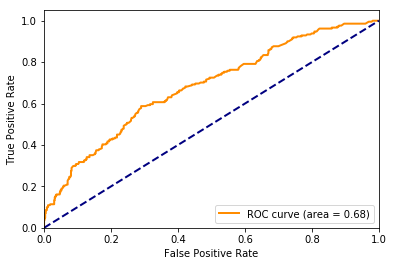

array([[592,   5],
       [191,  20]])

In [90]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

## 2.9 More Non-Text Features + + Topics + Bag Of Words 

In [267]:
train_data = train_json_with_test_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232, 18)
dev data shape: (808, 18)


In [268]:
def time_of_day(s):
    if s > 5 and s <= 12:
        return "morning"
    elif s > 12 and s <= 18:
        return "afternoon"
    elif s > 18 and s <= 23:
        return "night"
    else:
        return "latenight"
    
    
def day_of_week(s):
    if s >= 0 and s <= 3:
        return "weekday"
    else:
        return "weekend"
    
def season(month):
    if month>=3 and month<=5:
        return "spring"
    elif month>=6 and month <=8:
        return "summer"
    elif month>=9 and month <=11:
        return "fall"
    else:
        return "winter"

In [340]:
def construct_more_features(data):

    features=construct_features(data)
    
    # additional non-text features
    features['spring'] = ((pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's')).dt.month.apply(season) == "spring").astype(int) 
    features['summer'] = ((pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's')).dt.month.apply(season) == "summer").astype(int)
    features['fall'] = ((pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's')).dt.month.apply(season) == "fall").astype(int)
    features['winter'] = ((pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's')).dt.month.apply(season) == "winter").astype(int)
        

    features['posted_before_more']= (data['requester_number_of_posts_at_request'] > 100).astype(int)
    features['comments'] = (data['requester_number_of_comments_at_request'] > 20).astype(int)
    features['raop_comments'] = (data['requester_number_of_comments_in_raop_at_request'] > 10).astype(int)
    features['posted_in_raop_before_more']= (data['requester_number_of_posts_on_raop_at_request'] > 3).astype(int)
    
    #features['requester_days_since_first_post_on_raop_at_request'] = (data['requester_days_since_first_post_on_raop_at_request'] > 100).astype(int)
    
    #features['upvotes_minus_downvotes']= data['requester_upvotes_minus_downvotes_at_request'] > 
    #features['upvotes_plus_downvotes_at_request']=np.log(train_data['requester_upvotes_plus_downvotes_at_request']+1)
    #upvotes=data.apply(lambda row: (row['requester_upvotes_plus_downvotes_at_request'] + row['requester_upvotes_minus_downvotes_at_request'])/2,axis=1)
    #downvotes=data.apply(lambda row: (row['requester_upvotes_plus_downvotes_at_request']- row['requester_upvotes_minus_downvotes_at_request'])/2,axis=1)
    #features['vote_ratio']=upvotes/(upvotes+downvotes+1)
    
    return features

In [341]:
train_topic_features = construct_topic_features(train_data)
dev_topic_features = construct_topic_features(dev_data)



/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [342]:
train_other_features = construct_more_features(train_data)
dev_other_features = construct_more_features(dev_data)

In [343]:
vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,2), preprocessor=preprocessor,stop_words='english',norm='l2',sublinear_tf=True)
train_bag_of_words = vectorizer.fit_transform(train_data['full_text'])
dev_bag_of_words = vectorizer.transform(dev_data['full_text'])

In [344]:
train_features = hstack([train_other_features, train_topic_features, train_bag_of_words])
dev_features = hstack([dev_other_features, dev_topic_features, dev_bag_of_words])

In [345]:
lr = LogisticRegression(tol=0.01)
#parameters = {'C':[0.01, 0.1, 1, 10, 100]}
parameters = {'C':np.linspace(0.1, 1, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_features, train_labels)
pred_dev_prob = clf.predict_proba(dev_features)[:,1]
pred_dev_labels = clf.predict(dev_features)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.3545454545454545}


0.69834956774393298

In [346]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))

Request receives pizza = 211
Request failed to predict receiving pizza = 178


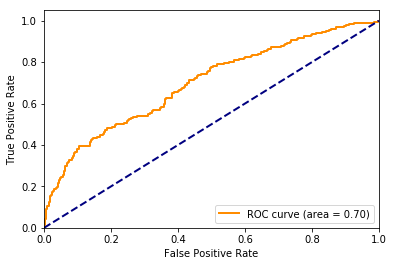

array([[584,  13],
       [178,  33]])

In [347]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

## 2.10 More Non-Text Features + Topics + Bag Of Words + LDA Topics 

In [ ]:
train_data = train_json_with_test_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

In [348]:
train_topic_features = construct_topic_features(train_data)
dev_topic_features = construct_topic_features(dev_data)

/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [349]:
train_other_features = construct_more_features(train_data)
dev_other_features = construct_more_features(dev_data)

In [350]:
vectorizer = TfidfVectorizer(min_df=5,ngram_range=(1,2), preprocessor=preprocessor,stop_words='english',norm='l2',sublinear_tf=True)
train_bag_of_words = vectorizer.fit_transform(train_data['full_text'])
dev_bag_of_words = vectorizer.transform(dev_data['full_text'])

In [351]:
vectorizer_lda = CountVectorizer(min_df=10,ngram_range=(1,1), preprocessor=preprocessor,stop_words='english') 
lda_bag_of_words = vectorizer_lda.fit_transform(train_data['full_text'])
lda_devbag_of_words = vectorizer_lda.transform(dev_data['full_text'])

In [352]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
lda = LDA(n_components=3, learning_method="batch", max_iter=30,learning_decay=.7, random_state=42)

train_lda_topics = lda.fit_transform(lda_bag_of_words)
dev_lda_topics=lda.transform(lda_devbag_of_words)

train_features = hstack([train_other_features, train_topic_features, train_lda_topics, train_bag_of_words])
dev_features = hstack([dev_other_features, dev_topic_features, dev_lda_topics, dev_bag_of_words])

In [353]:
lr = LogisticRegression(tol=0.01)
#parameters = {'C':[0.01, 0.1, 1, 10, 100]}
parameters = {'C':np.linspace(0.1, 1, 100)}
clf = GridSearchCV(lr, parameters)
clf.fit(train_features, train_labels)
pred_dev_prob = clf.predict_proba(dev_features)[:,1]
pred_dev_labels = clf.predict(dev_features)

print(clf.best_params_)
roc_auc_score(dev_labels, pred_dev_prob, average='micro')

{'C': 0.23636363636363636}


0.70081052974191649

In [354]:
print("Request receives pizza = {}".format(np.sum(dev_labels)))
print("Request failed to predict receiving pizza = {}".format(np.sum(dev_labels[dev_labels != pred_dev_labels])))

Request receives pizza = 211
Request failed to predict receiving pizza = 181


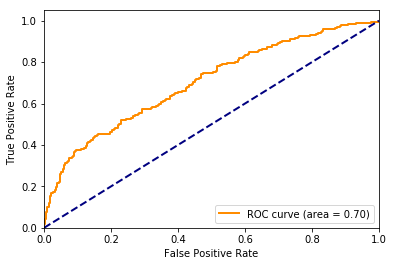

array([[586,  11],
       [181,  30]])

In [355]:
plot_roc(dev_labels, pred_dev_prob)
confusion_matrix(dev_labels, pred_dev_labels)

# 3.0 Try to augment the dataset to balance the 2 classes

In [405]:
train_data = train_json_with_test_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232, 18)
dev data shape: (808, 18)


In [406]:
train_other_features = construct_more_features(train_data)
dev_other_features = construct_more_features(dev_data)

In [409]:
train_data['full_text'] = train_data['request_text_edit_aware'] + ' ' + train_data['request_title']
dev_data['full_text'] = dev_data['request_text_edit_aware'] + ' ' + dev_data['request_title']
       

/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [418]:
# mean for each non-text feature that receives pizza 
other_features_mean = train_other_features[train_labels == 1].mean()
other_features_std = train_other_features[train_labels == 1].std()

mean_text_len = train_data[train_labels == 1]['full_text'].apply(lambda x: len(x.split())).mean()
std_text_len = train_data[train_labels == 1]['full_text'].apply(lambda x: len(x.split())).std()

mean_utc_time = train_data[train_labels == 1]['unix_timestamp_of_request_utc'].mean()
std_utc_time = train_data[train_labels == 1]['unix_timestamp_of_request_utc'].std()

mean_posted_in_raop_before = train_data[train_labels == 1]['requester_number_of_posts_on_raop_at_request'].mean()
std_posted_in_raop_before = train_data[train_labels == 1]['requester_number_of_posts_on_raop_at_request'].std()


In [415]:
vectorizer = CountVectorizer(min_df = 2, ngram_range=(1,1), preprocessor=preprocessor,stop_words='english')
train_bag_of_words = vectorizer.fit_transform(train_data.full_text)
dev_bag_of_words = vectorizer.transform(dev_data.full_text)

In [419]:
augment_sample_size = 1000

# probability for bag of words
nb = MultinomialNB()
nb.fit(train_bag_of_words, train_labels)

prob = np.zeros(nb.feature_log_prob_.shape)

for i in range(nb.feature_log_prob_.shape[0]): 
    for j in range(nb.feature_log_prob_.shape[1]):
        prob[i,j] = np.exp(nb.feature_log_prob_[i][j])


# generate new samples
new_train_other = pd.DataFrame(columns = ['community_age', 'first_half_of_month', 'gratitude', 'include_image', \
                                         'reciprocity', 'len_request', 'karma', 'posted_in_raop_before', \
                                         'posted_before', ])
new_train_text = pd.DataFrame(columns = ['request_text_edit_aware'])


for i in range(augment_sample_size):
    
    # generate other features
    community_age = int(other_features_std.community_age * np.random.rand() + other_features_mean.community_age)
    first_half_of_month = np.random.choice(2, 1, p = [1-other_features_mean.first_half_of_month, other_features_mean.first_half_of_month])[0]

gratitude = np.random.choice(2, 1, p = [1-other_features_mean.gratitude, other_features_mean.gratitude])[0]
    include_image = np.random.choice(2, 1, p = [1-other_features_mean.include_image, other_features_mean.include_image])[0]
reciprocity = np.random.choice(2, 1, p = [1-other_features_mean.reciprocity, other_features_mean.reciprocity])[0]
    
    length = int(std_text_len * np.random.rand() + mean_text_len)
    len_request = int(length > 100)
    karma = int(other_features_std.karma * np.random.rand() + other_features_mean.karma)
    
    requester_number_of_posts_on_raop_at_request = int(std_posted_in_raop_before * np.random.rand() + mean_posted_in_raop_before)
    posted_in_raop_before = int(requester_number_of_posts_on_raop_at_request > 0)
    
    posted_before = np.random.choice(2, 1, p = [1-other_features_mean.posted_before, other_features_mean.posted_before])[0]
    
    
    # additional non-text features
    utc = int(std_utc_time * np.random.rand() + mean_utc_time)
    spring =
    
    
    features['spring'] = ((pd.to_datetime(utc,unit = 's')).dt.month.apply(season) == "spring").astype(int) 
    features['summer'] = ((pd.to_datetime(utc,unit = 's')).dt.month.apply(season) == "summer").astype(int)
    features['fall'] = ((pd.to_datetime(utc,unit = 's')).dt.month.apply(season) == "fall").astype(int)
    features['winter'] = ((pd.to_datetime(utc,unit = 's')).dt.month.apply(season) == "winter").astype(int)
        

    posted_before_more = np.random.choice(2, 1, p = [1-other_features_mean.requester_number_of_posts_at_request, \
                                                     other_features_mean.requester_number_of_posts_at_request])[0]   
    
    comments = np.random.choice(2, 1, p = [1-other_features_mean.requester_number_of_comments_at_request, \
                                           other_features_mean.requester_number_of_comments_at_request])[0] 
    
    raop_comments = np.random.choice(2, 1, p = [1-other_features_mean.requester_number_of_comments_in_raop_at_request, \
                                           other_features_mean.requester_number_of_comments_in_raop_at_request])[0] 
    
    posted_in_raop_before_more = int(requester_number_of_posts_on_raop_at_request > 3)
    

    
    
    
    new_train_other.loc[i] = [community_age, first_half_of_month, gratitude, include_image, \
                                reciprocity, len_request, karma, posted_in_raop_before, \
                                posted_before, money, work, college, family, friend]
    
    # generate text
    new_text = []
    for j in np.random.choice(len(vectorizer.vocabulary_), size=length, p=prob[1,:]):
        new_text.append(list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(j)])
    
    new_train_text.loc[i] = " ".join(new_text)
    
new_train_other = new_train_other.astype(int)

IndentationError: unexpected indent (<ipython-input-419-5db40f289ff3>, line 26)

# 4.0 EDA - XGABoost 

## 4.1 Just Non-Text Features

In [675]:
train_data = train_json_df
train_labels = train_json_df.requester_received_pizza.astype(int).as_matrix()

train_data, dev_data, train_labels, dev_labels = \
            train_test_split(train_data, train_labels, test_size=0.2, random_state=42)
    
print('training data shape:', train_data.shape)
print('dev data shape:', dev_data.shape)

training data shape: (3232, 32)
dev data shape: (808, 32)


In [680]:
train_data['full_text']=train_data['request_text_edit_aware'] +' '+train_data['request_title']
dev_data['full_text']=dev_data['request_text_edit_aware'] +' '+dev_data['request_title']

/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/lauc136/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [685]:
def construct_features(data):
    features=pd.DataFrame()
    
    features['community_age'] = (pd.to_datetime(data['unix_timestamp_of_request_utc'],utc = True, unit = 's') - \
                                pd.to_datetime('2010-12-8', format='%Y-%m-%d')).astype('timedelta64[D]')
    
    features['community_age'] = (features['community_age'] * 10./features.community_age.max()).astype(int)

    features['first_half_of_month']=(pd.to_datetime(data['unix_timestamp_of_request_utc'],unit = 's').dt.day <= 15).astype(int) 

    features['gratitude'] = data['request_text_edit_aware'].apply( \
                                    lambda x: 1 if re.search("thank|appreciate|advance|consider", x) else 0)
    features['include_image'] = data['request_text_edit_aware'].apply(lambda x: 1 if re.search("http|www|screenshot|photo|image", x) else 0)

    features['reciprocity'] = data['request_text_edit_aware'].apply(\
                                    lambda x:1 if re.search("repay|pay.+back|pay.+forward|return.+favor|reciprocate", x) else 0)
    features['len_request']= data['request_text_edit_aware'].apply(len)

    features['karma']=(data['requester_upvotes_minus_downvotes_at_request']* 10.\
                                         /data.requester_upvotes_minus_downvotes_at_request.max()).astype(int)

    features['posted_in_raop_before']= data['requester_number_of_posts_on_raop_at_request']
    
    features['posted_before']= data['requester_number_of_posts_at_request']
  

In [686]:
#https://www.timeanddate.com/calendar/aboutseasons.html
def ts_to_season(month):
    if month>=3 and month<=5:
        return "spring"
    elif month>=6 and month <=8:
        return "summer"
    elif month>=9 and month <=11:
        return "fall"
    else:
        return "winter"

In [687]:
train_other_features = construct_features(train_data)
dev_other_features = construct_features(dev_data)

In [688]:
import xgboost as xgb

#create dmatrices
dtrain = xgb.DMatrix(train_other_features, train_labels)
dtest = xgb.DMatrix(dev_other_features, dev_labels)

#booster parameter
param = {'max_depth':15, 'eta': .015, 'silent': 1, 'objective': 'binary:logistic'
         , 'scale_pos_weight': 3.06,'max_delta_step':1,'subsample':.9,'seed':42}#9 depth if sublin false
param['nthread'] = 4
param['eval_metric'] = 'auc'

#specify validation set to watch performance
evallist = [(dtest, 'eval'), (dtrain, 'train')]

#train model
num_round = 500
bst = xgb.train(param.items(), dtrain, num_round, evallist)

[0]	eval-auc:0.599161	train-auc:0.713412
[1]	eval-auc:0.60962	train-auc:0.718666
[2]	eval-auc:0.612367	train-auc:0.720399
[3]	eval-auc:0.614304	train-auc:0.721679
[4]	eval-auc:0.612327	train-auc:0.72237
[5]	eval-auc:0.612144	train-auc:0.72306
[6]	eval-auc:0.610481	train-auc:0.722961
[7]	eval-auc:0.612942	train-auc:0.723237
[8]	eval-auc:0.614804	train-auc:0.723947
[9]	eval-auc:0.612704	train-auc:0.724271
[10]	eval-auc:0.612061	train-auc:0.72478
[11]	eval-auc:0.613299	train-auc:0.725311
[12]	eval-auc:0.612426	train-auc:0.725408
[13]	eval-auc:0.611744	train-auc:0.725988
[14]	eval-auc:0.613093	train-auc:0.726298
[15]	eval-auc:0.613859	train-auc:0.726844
[16]	eval-auc:0.614078	train-auc:0.727167
[17]	eval-auc:0.613887	train-auc:0.727562
[18]	eval-auc:0.612569	train-auc:0.727744
[19]	eval-auc:0.612958	train-auc:0.727791
[20]	eval-auc:0.612799	train-auc:0.727771
[21]	eval-auc:0.61295	train-auc:0.727719
[22]	eval-auc:0.613649	train-auc:0.728001
[23]	eval-auc:0.614665	train-auc:0.727904
[24]	ev

[195]	eval-auc:0.602936	train-auc:0.740218
[196]	eval-auc:0.603158	train-auc:0.740256
[197]	eval-auc:0.603174	train-auc:0.740291
[198]	eval-auc:0.603206	train-auc:0.740355
[199]	eval-auc:0.603333	train-auc:0.740369
[200]	eval-auc:0.603396	train-auc:0.740398
[201]	eval-auc:0.603571	train-auc:0.740447
[202]	eval-auc:0.603269	train-auc:0.740471
[203]	eval-auc:0.603237	train-auc:0.740511
[204]	eval-auc:0.603785	train-auc:0.740541
[205]	eval-auc:0.603134	train-auc:0.740591
[206]	eval-auc:0.603309	train-auc:0.740612
[207]	eval-auc:0.603055	train-auc:0.740675
[208]	eval-auc:0.603285	train-auc:0.740718
[209]	eval-auc:0.603174	train-auc:0.740747
[210]	eval-auc:0.603245	train-auc:0.740803
[211]	eval-auc:0.603047	train-auc:0.740791
[212]	eval-auc:0.603404	train-auc:0.740844
[213]	eval-auc:0.603039	train-auc:0.740877
[214]	eval-auc:0.603134	train-auc:0.740917
[215]	eval-auc:0.603015	train-auc:0.741054
[216]	eval-auc:0.60288	train-auc:0.741063
[217]	eval-auc:0.602904	train-auc:0.741081
[218]	eval-a

[387]	eval-auc:0.597903	train-auc:0.745287
[388]	eval-auc:0.597807	train-auc:0.745322
[389]	eval-auc:0.597982	train-auc:0.745339
[390]	eval-auc:0.598236	train-auc:0.745354
[391]	eval-auc:0.59826	train-auc:0.745353
[392]	eval-auc:0.598141	train-auc:0.745376
[393]	eval-auc:0.597895	train-auc:0.745393
[394]	eval-auc:0.597974	train-auc:0.745432
[395]	eval-auc:0.598093	train-auc:0.74546
[396]	eval-auc:0.597903	train-auc:0.745469
[397]	eval-auc:0.597871	train-auc:0.74547
[398]	eval-auc:0.59768	train-auc:0.745498
[399]	eval-auc:0.597974	train-auc:0.74552
[400]	eval-auc:0.598093	train-auc:0.745552
[401]	eval-auc:0.598022	train-auc:0.74555
[402]	eval-auc:0.597855	train-auc:0.74557
[403]	eval-auc:0.598061	train-auc:0.745606
[404]	eval-auc:0.598038	train-auc:0.745619
[405]	eval-auc:0.597958	train-auc:0.745628
[406]	eval-auc:0.597926	train-auc:0.745644
[407]	eval-auc:0.597736	train-auc:0.745647
[408]	eval-auc:0.597855	train-auc:0.745633
[409]	eval-auc:0.597903	train-auc:0.745662
[410]	eval-auc:0.5